# Lab Four: Evaluation and Multi-Layer Perceptron

# James Thomas, Xiaoxian Jing, Kuang Yan

 1. [Dataset Selection](#data)<br>
 2. [Preparation](#prep)<br>
  2.1 [Business Case](#business_case)<br>
  2.2 [Define Class Variables](#class_variables)<br>
 3. [Evaluation](#eval)<br>
  3.1 [Metric](#metric)<br>
  3.2 [Test-Train Split](#split)<br>
 4. [Modeling](#modeling)<br>
  4.1 [Multi-Layer Perceptron](#mlp)<br>
  4.2 [Hyper Parameter](#hyper_parameters)<br>
  4.3 [Visualize Gradients](#visualize)<br>
 5. [Exceptional Work](#exceptional)<br>
  4.1 [Additional Analysis](#additional_analysis)<br>
  4.2 [Phi Functions](#phi_functions)<br>
 5. [Final Thoughts](#thoughts)<br>
  
[//]: # (put the html anchors above the titles for better scrolling)
[//]: # (note the <br>, and why do I need .. for 3rd level?, maybe I should just use pureish html)

<a id="data"></a>
## Dataset Selection
Select a dataset identically to the way you selected for lab one or lab three (table data or image data). You are not required to use the same dataset that you used in the past, but you are encouraged. You must identify a classification task from the dataset that contains __three or more classes__ to predict. That is, it cannot be a binary classification; it must be multi-class prediction. 

<a id="prep"></a>
## Preparation __(15 points total)__

<a id="business_case"></a>
### Business Case / Use Case

>__[5 points]__ _(mostly the same processes as from previous lab)_ Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the task is and what parties would be interested in the results. How well would your prediction algorithm need to perform to be considered useful by interested parties?

For this project we will return to the diabetes dataset we used for Lab1. Briefly, this dataset contains information regarding diabetic patients who were admitted to the hospital.

This dataset contains labels that characterize whether the patient was readmitted to the hospital in less than 30 days, readmitted to the hospital after more than 30 days, or not readmitted at all. Predicting these labels will be our classification task. 

There are two potential sets of parties interested in these results. 

- First, emergency medical care centers. These care centers will likely be interested in the results because of the insight they may provide for the day to day operations of the centers. We may discover that certain types of patients are much more likely to be readmitted to an emergency medical care center. This information could be used by the care centers to provide extra attention to the most at-risk patients once identified. In this case, the model would likely be deployed so that the healthcare professionals can have feedback as soon as possible. Throughout this project, we will focus on this possibility so as not to split our time and energy.

- Second, special focus groups, such as the [American Diabetes Association](http://www.diabetes.org/). These organizations can use the insight gained from our studies to issue standards or suggestions. These standards or suggestions could then be implemented at individual care centers. Since the ADA is a large organization with a relative large sphere of influence, these suggestions could help ensure parity accross a variety of care centers. In this case, the model would mostly be used for offline analysis. For this project, we will not focus on this possibility.

<a id="class_variables"></a>
### Define Class Variables

> __[10 points]__ _(mostly the same processes as from lab one)_ Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. __Describe the final dataset that is used for classification__ (include a description of any newly formed variables you created).

In [1]:
# load the full dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ggplot')
%matplotlib inline

full_df = pd.read_csv('data/diabetic_data.csv')

full_df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

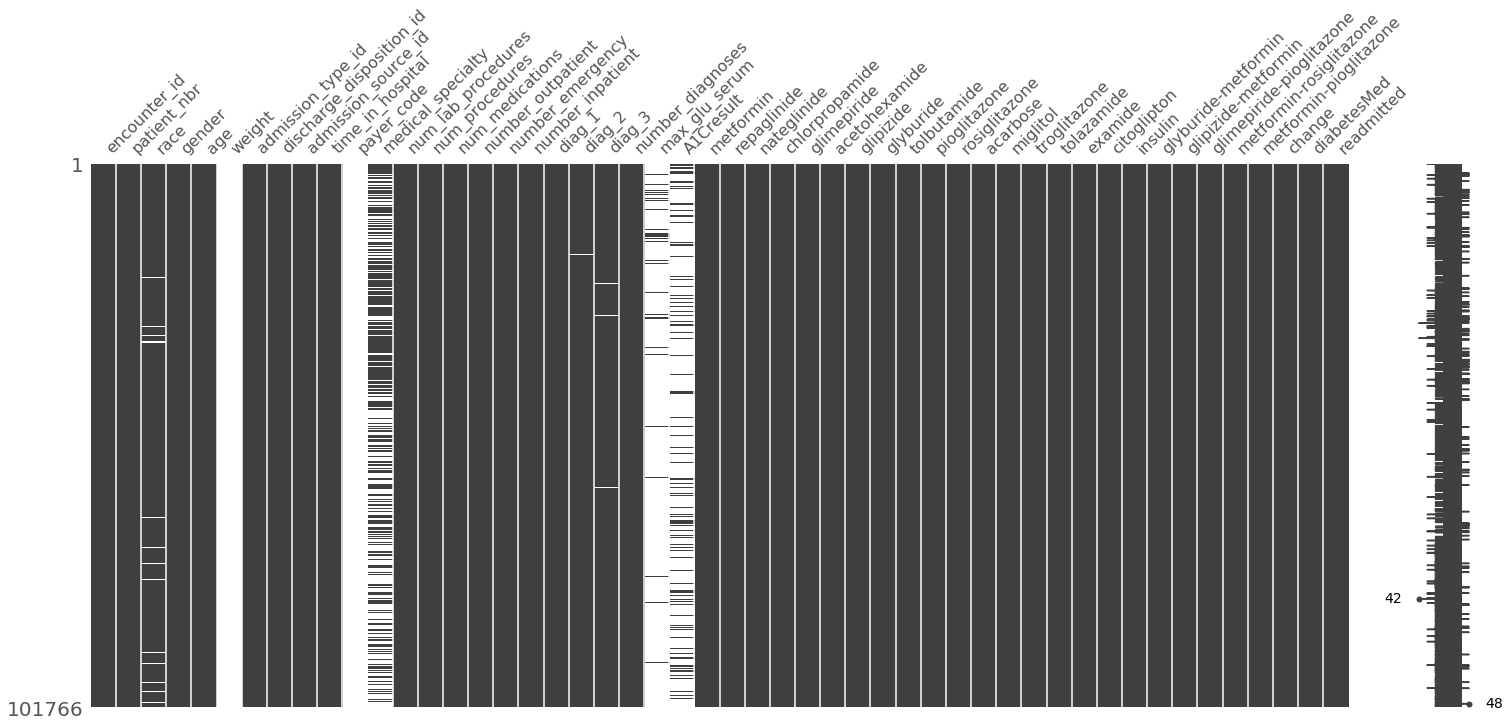

In [2]:
# now convert columns that should be numeric to numeric types,
# then drop the columns missing too much data and then the rows with any missing data. 

import os
if os.getcwd().find('jamesthomas'):
    import sys
    sys.path.append('/users/jamesthomas/python_packages/')
    import missingno as mn
        
# first force the columns that should be numeric to numeric
numeric_cols = ['weight','payer_code']
full_df[numeric_cols]=full_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# now replace the '?' in the string data
full_df.replace({'?':None,'None':None}, inplace = True)
mn.matrix(full_df)

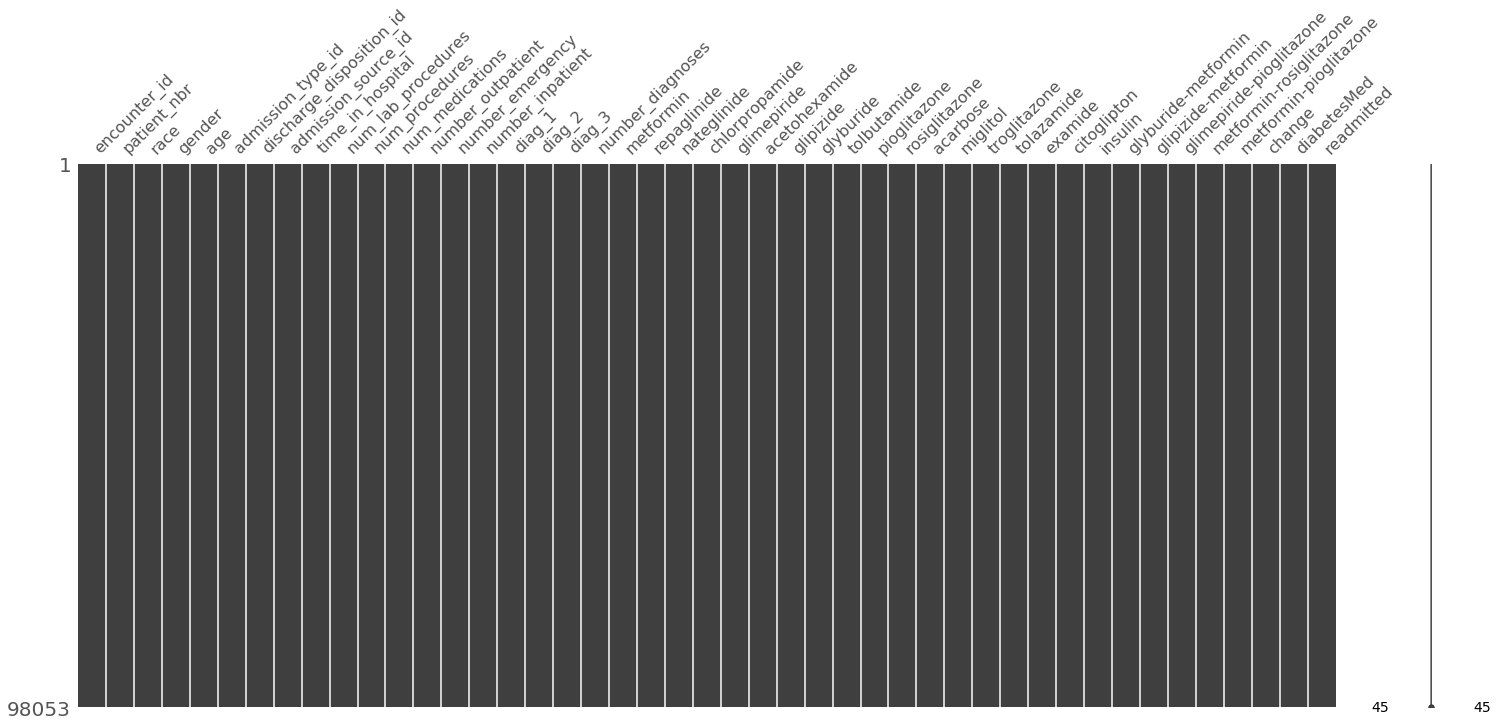

In [3]:
# then drop the columns missing too much data and then the rows with any missing data. 

cols = list(full_df)
datas = list(full_df.isnull().sum())
size = full_df.shape[0]
drop_cols = []
threshold = 0.08
for i in range(len(cols)):
    if datas[i]/size > threshold:
        drop_cols.append(cols[i])

full_df.drop(drop_cols, axis=1, inplace=True)
full_df.dropna(inplace=True)

mn.matrix(full_df)

In [4]:
def one_hot_encode(df, column):
    '''If the column only contains a single value, there is no information so don't do anything,
    otherwise one hot encode the column
    '''
    col_names = []
    if len(df[col].unique()) != 1:
        # more than one value in category
        df[column] = pd.Categorical(df[column])
        dfDummies = pd.get_dummies(df[column], prefix = column+'_category')
        col_names.append(list(dfDummies))
        df = pd.concat([df, dfDummies], axis=1)
    return df, col_names

def diag_categorize(val):
    '''More information about the categories can be found at http://www.icd9data.com/
    '''
    try:
        val = float(val)
        if val < 140:
            return('Infectious and Parasitic Disease')
        elif val < 240:
            return('Neoplasms')
        elif val < 280:
            return('Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders')
        elif val < 290:
            return('Diseases Of The Blood And Blood-Forming Organs')
        elif val < 320:
            return('Mental Disorders')
        elif val < 390:
            return('Diseases Of The Nervous System And Sense Organs')
        elif val < 460:
            return('Diseases Of The Circulatory System')
        elif val < 520:
            return('Diseases Of The Circulatory System')
        elif val < 580:
            return('Diseases Of The Digestive System')
        elif val < 630:
            return('Diseases Of The Genitourinary System')
        elif val < 680:
            return('Complications Of Pregnancy, Childbirth, And The Puerperium')
        elif val < 710:
            return('Diseases Of The Skin And Subcutaneous Tissue')
        elif val < 740:
            return('Diseases Of The Musculoskeletal System And Connective Tissue')
        elif val < 760:
            return('Congenital Anomalies')
        elif val < 780:
            return('Certain Conditions Originating In The Perinatal Period')
        elif val < 800:
            return('Symptoms, Signs, And Ill-Defined Conditions')
        else:
            return('Injury And Poisoning')
    except:
        if val[0]=='V':
            return('Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services')
        elif val[0]=='E':
            return('Supplementary Classification Of External Causes Of Injury And Poisoning')
        else:
            print(val)
            return(None)

In [5]:
# these are the columns that use the ICD9 data

explain_list = ['diag_1', 'diag_2', 'diag_3']
for diag in explain_list:
    full_df[diag+'_explain'] = full_df[diag].apply(diag_categorize)

In [6]:
# these are the columns that need one hot encoded

one_hot_encode_list = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide',
                       'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone',
                       'tolazamide','examide','citoglipton','glyburide-metformin','glipizide-metformin',
                       'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone',
                       'diag_1_explain','diag_2_explain','diag_3_explain','race','admission_type_id',
                       'discharge_disposition_id','admission_source_id','insulin']

# the names are so we don't use standard scalar on one hot encoded columns
one_hot_encoded_names = []
for col in one_hot_encode_list:
    full_df, one_hot_names = one_hot_encode(full_df, col)
    one_hot_encoded_names.append(one_hot_names)

full_df.drop(one_hot_encode_list+explain_list, axis=1, inplace=True)

In [7]:
# Now we will convert the 'patient_nbr' column to a new column that shows counts how many times the patient visitied
# the hospital in the study

full_df['freq'] = full_df.groupby('patient_nbr')['patient_nbr'].transform('count')

In [8]:
# these are the columns that are no longer relevant, either because we transformed the data or it is just an id

drop_not_relevant = ['encounter_id', 'patient_nbr']
full_df.drop(drop_not_relevant, axis=1, inplace=True)

In [9]:
# now label encoding
full_df['age'] = full_df['age'].replace({'[0-10)':0,'[10-20)':1,'[20-30)':2,'[30-40)':3,'[40-50)':4,
                                         '[50-60)':5,'[60-70)':6,'[70-80)':7,'[80-90)':8,'[90-100)':9})
full_df['gender'] = full_df['gender'].replace({'Male':0,'Female':1,'Unknown/Invalid':None})
full_df['change'] = full_df['change'].replace({'Ch':0,'No':1})
full_df['diabetesMed'] = full_df['diabetesMed'].replace({'Yes':0,'No':1})

In [10]:
full_df.dropna(inplace=True) # to drop any None types that come up from the conversions

In [11]:
list(full_df)

['gender',
 'age',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'change',
 'diabetesMed',
 'readmitted',
 'metformin_category_Down',
 'metformin_category_No',
 'metformin_category_Steady',
 'metformin_category_Up',
 'repaglinide_category_Down',
 'repaglinide_category_No',
 'repaglinide_category_Steady',
 'repaglinide_category_Up',
 'nateglinide_category_Down',
 'nateglinide_category_No',
 'nateglinide_category_Steady',
 'nateglinide_category_Up',
 'chlorpropamide_category_Down',
 'chlorpropamide_category_No',
 'chlorpropamide_category_Steady',
 'chlorpropamide_category_Up',
 'glimepiride_category_Down',
 'glimepiride_category_No',
 'glimepiride_category_Steady',
 'glimepiride_category_Up',
 'acetohexamide_category_No',
 'acetohexamide_category_Steady',
 'glipizide_category_Down',
 'glipizide_category_No',
 'glipizide_category_Steady',
 'glipizide_category_Up',
 'g

In [13]:
# normalize the columns so that the response is not dominated by a few columns with large values
       
standard_scalar_list = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                        'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'freq']

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
full_df[standard_scalar_list] = scalar.fit_transform(full_df[standard_scalar_list])

PCA model built!
Orginal data dimension is 187. Embedded data dimension is 187


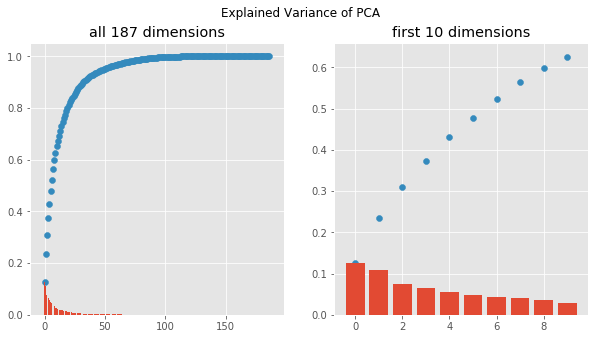

In [16]:
# now look at PCA
from sklearn.decomposition import PCA
import seaborn as sns

# first split the data from the target
data_cols = list(full_df)
data_cols.remove('readmitted')
data = full_df[data_cols]
target = full_df['readmitted']

# now do PCA on the data
pca = PCA(n_components=len(data_cols), random_state=1)
print('PCA model built!')

data_pca_fit = pca.fit_transform(data.copy())
#X_PCA = X_PCA_fit.transform(X)
explained_var = pca.explained_variance_ratio_
print("Orginal data dimension is {}. Embedded data dimension is {}".format(data.shape[-1], data_pca_fit.shape[-1]))
#print("cumulative explained variance : {}".format(np.cumsum(explained_var)))

fig = plt.figure(figsize = (10,5))
fig.suptitle('Explained Variance of PCA')
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.set_title('all {} dimensions'.format(len(data_cols)))
ax1.bar(np.arange(0,len(explained_var),1),explained_var)
ax1.scatter(np.arange(0,len(explained_var),1),np.cumsum(explained_var))
ax2.set_title('first 10 dimensions')
ax2.bar(np.arange(0,10,1),explained_var[:10])
ax2.scatter(np.arange(0,10,1),np.cumsum(explained_var[:10]))
plt.show()

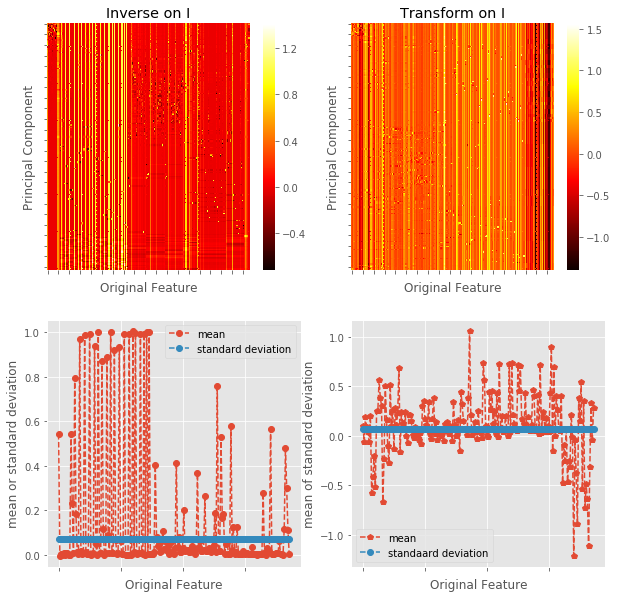

In [47]:
# now look at the features most contributing to the PCA

inv_dat = pca.inverse_transform(np.eye(data.shape[1]))
mean = inv_dat.mean(axis=0)
std = inv_dat.std(axis=0)

rot_dat = pca.transform(np.eye(data.shape[1]))
rot_mean = rot_dat.mean(axis=0)
rot_std = rot_dat.std(axis=0)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))

axes[0,0] = sns.heatmap(inv_dat, cmap="hot", cbar=True, ax=axes[0,0])
axes[0,0].set(xlabel='Original Feature', ylabel='Principal Component', yticklabels=[], xticklabels=[], title='Inverse on I')

axes[1,0].plot(mean, '--o', label='mean')
axes[1,0].plot(std, '--o', label='standard deviation')
axes[1,0].set_xlabel('Original Feature')
axes[1,0].set_ylabel('mean or standard deviation')
axes[1,0].set_xticklabels([])
axes[1,0].legend()

axes[0,1] = sns.heatmap(rot_dat, cmap="hot", cbar=True, ax=axes[0,1])
axes[0,1].set(xlabel='Original Feature', ylabel='Principal Component', yticklabels=[], xticklabels=[], title='Transform on I')

axes[1,1].plot(rot_mean, '--p', label='mean')
axes[1,1].plot(rot_std, '--o', label='standaard deviation')
axes[1,1].set(xlabel='Original Feature', ylabel='mean of standard deviation', xticklabels=[])
axes[1,1].legend()

plt.show()

for a threshold of 0.1 we keep 44 features


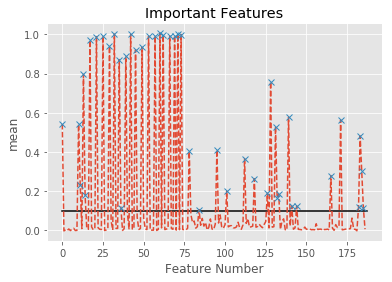

In [36]:
threshold = 0.1
ids = np.argwhere(mean > threshold)[:,0]
important_cols = [data_cols[i] for i in ids]
important_means = [mean[i] for i in ids]
print('for a threshold of {} we keep {} features'.format(threshold, len(important_cols)))
      
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Important Features')
ax.set_ylabel('mean')
ax.set_xlabel('Feature Number')
ax.plot([0,len(mean)], [threshold,threshold], 'k-', label = 'threshold')
ax.plot(mean, '--', label = 'mean')
ax.plot(ids, important_means, 'x')
plt.show()

In [ ]:
# now save the csv so we don't have to rerun these cells each time
full_df.to_csv('data/processed_data.csv',index=False)

<a id="evaluation"></a>
## Evaluation (30 points total)


<a id="metric"></a>
### Metric

>__[15 points]__ Choose and explain what metric(s) you will use to evaluate your algorithm’s generalization performance. You should give a __detailed argument for why this (these) metric(s) are appropriate__ on your data. That is, why does the metric evaluate performance in terms of the business case you argued for. Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

<a id="split"></a>
### Test-Train Split

>__[15 points]__ Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Why?). __Explain why your chosen method is appropriate or use more than one method as appropriate__. For example, if you are using time series data then you should be using continuous training and testing sets across time. Convince the reader that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 
- __Important__: You should use your chosen evaluation criteria and chosen method for dividing train/test data throughout the report. For example, arguing that f-score is the best evaluation method, but then using accuracy in a grid search will be __regarded as a conceptual error__ and graded accordingly. 

In [ ]:
from sklearn.model_selection import train_test_split

# split the data and the target
data_cols = list(full_df)
data_cols.remove('readmitted')
data = full_df[data_cols]
target = full_df['readmitted']
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2)

As a general rule of thumb, an 80/20 split for the training and testing data is a good starting point. The key point is to make sure that the full model space is covered by the training and testing data. 

Moreover, since we are using logistic regression which only splits the full parameter space using a single hyper-plane, we may not even need the full parameter space to be populated. It is acceptable for the space to be sufficiently populated for the model to find the appropriate hyper-plane.

In our case we have around 100,000 instances in our data in the set and we only have around 75 featrues (parameters to train), we could use a smaller training set and still have good accuracy. In some parts of this project we used as small as 10% of the data for training to reduce training time. 

<a id="modeling"></a>
## Modeling (45 points total)

> All modeling code must be written using only the instructor's template code. Do NOT copy this implementation form anywhere online. Not fully implementing the back propagation algorithm will result in a zero for the entire assignment.

<a id="mlp"></a>
### Multi-Layer Perceptron

>__[20 points]__ Create a custom implementation of the multi-layer perceptron. Start with the implementation given to you in the course. Update the MLP class to:
- When instantiated, use a selectable phi function for the initial layer: either sigmoid or linear
- Use a selectable cost function when instantiated: either quadratic or cross entropy
- Add support for any number of hidden layers (user customizable).

<a id="hyper_parameters"></a>
### Hyper Parameters

>__[15 points]__ Tune the hyper-parameters of your MLP model (phi function, objective function, and number of layers). While tuning hyper-parameters, analyze the results using your chosen metric(s) of evaluation. __Visualize the evaluation metric(s) versus the hyper-parameters__. Conclude what combination of parameters are best.

<a id="visualize"></a>
### Visualize Gradients

>__[10 points]__ Visualize the magnitude of the gradients in each layer of the neural network versus the training iteration. Do the gradients stay consistent in each layer?

<a id="exceptional"></a>
## Exceptional Work

<a id="additional_analysis"></a>
### Additional Analysis

> You have free reign to provide additional analyses. __One idea__: Update the code to use either "one-versus-all" or "one-versus-one" extensions of binary to multi-class classification. 

We implemented a "one-verses-all" technique in the previous code. See [One-Verses-All Logistic Regression](#1vall).

<a id="phi_function"></a>
### Phi Functions

> One idea (__required for 7000 level students__): Implement two more phi functions: ReLU and SiLU (also called Swish). Compare their performance to the linear and sigmoid phi functions.

<a id="thoughts"></a>
## Final Thoughts

- sci-kit learn has many useful built in models and rewriting them doesn't make much sense in many cases, with learning exercises being a notable exception.

- The $C$ parameter in [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) is the inverse of the regularization strength. 

- The highest accuracy we achieved with linear regression classifiers was only around 60%. This is likely not high enough to be used in a medical situation. This means that we will still need to pursue other methods to increase our accuracy (or f1 scores) to acceptable levels for health care. 